## Dimensions of the Beam

In [1]:
import sympy as sp
import numpy as np
import matplotlib.pylab as plt
sp.init_printing()

In [2]:
b_w  = sp.Symbol('b_w', nonnegative = True)
d = sp.Symbol('d', nonnegative = True)
h = sp.Symbol('h', nonnegative = True)
f_c = sp.Symbol('f_c', nonnegative = True)
d_b =  sp.Symbol('d_b', nonnegative = True)
n = sp.Symbol('n', nonnegative = True)

In [3]:
params = {
    b_w : 75,#mm
    d : 230, #mm
    h : 250, #mm
    f_c : 37.9, #MPa
    d_b : 25.4, #mm
    n : 4, 
    h : 250, #mm
    
}

| Parameters | Cavagnis(Thesis) | Huber(Journal) | Tureyan(Journal) |
| --- | --- | --- |--- |
| $B$| $250 \;mm$| $75 \;mm$ | $457 \;mm$ |
| $D$|  $570 \;mm$ | $230 \;mm$ | $360 \;mm$ |
| $H$| $600 \;mm$ | $250 \;mm$ | $406 \;mm$ |
| $f_c$| $33.3 \;\frac{N}{mm^2}$ | $37.9 \;\frac{N}{mm^2}$ | $34.5 \;\frac{N}{mm^2}$ |
| $f_t$| $0.3 f_c^{2/3}$ and $0.3 (50 f_c)^{1/3}$ | $3.06\;\frac{N}{mm^2}$ | $-$ |
| $d_a$| $ 16 \;mm$ | $ 22 \;mm$ | $19 \;mm$ |
| $n$| $2$ | $4$ | $7 $ |
| $d_s$| $28 \;mm$ | $25.4 \;mm$ | $50.8 \;mm$ |
| $\rho$| $0.88 \%$ | $1.2 \%$ |  $0.96 \%$ |
| $L$| $3870 \;mm$ | $5.6H$| $330 \;mm$ |
| $L_{cc}$| $2700 \;mm$ | $3.04D$ | $165 \;mm$ |

*$0.3 f_c^{2/3}\; for \; f_c \;< 50 (\mathrm{MPa})\;  0.3 (50 f_c)^{1/3}\; for \; f_c > \;50 \mathrm{MPa}$

## Reinforcement Area

In [4]:
A_b = n * np.pi * d_b**2 / 4 #mm2
A_b.subs(params)

## fib Model Code 2010
In the case of monotonic loading, the reference $\tau_{b0}$ value of the bond stresses between concrete and reinforcing bar for pullout and splitting failure can be calculated as a function of the relative displacement $s$ parallel to the bar axis.
\begin{equation}
\tau_{b0} = \tau_{b\, max} \left(\frac{s}{s_1}\right)\,\, \mathrm{for}\,\,0\leq s \leq s_1 \\
\tau_{b0} = \tau_{b\, max} \,\, \mathrm{for}\,\,s_1 \leq s \leq s_2 \\
\tau_{b0} = \tau_{b\, max} - \left( \tau_{b\, max} - \tau_{bf} \left(\frac{s -s_2}{s_3 - s_2}\right) \right) \,\, \mathrm{for}\,\,s_2 \leq s \leq s_3 \\
\tau_{b0} = \tau_{bf} \,\, \mathrm{for}\,\,s_3 < s \\
\end{equation}
The parameters to be applied depend primarily on the failure mode i.e. Pullout or Splitting.
### Pullout
#### Good Bond Condition 
\begin{equation}
\tau_{b\,max} = 2.5 \sqrt{f_{c}} \,;\, s_1  = 1.00 \,;\, s_2 = 2.00 \,;\, s_3 = c_{clear} \,;\, \alpha = 0.4 \,;\, 
\tau_{bf} = 0.4 \tau_{bmax} \\
\end{equation}

In [5]:
s  = sp.Symbol('s', nonnegative = True)
s_1  = sp.Symbol('s_1', nonnegative = True)
s_2 = sp.Symbol('s_2', nonnegative = True)
s_3 = sp.Symbol('s_3', nonnegative = True)
alpha = sp.Symbol(r'\alpha', nonnegative = True)

In [6]:
tau_b_max = 2.5 * sp.sqrt(f_c)
tau_b_max

In [7]:
params_bm = {
    f_c : 37.9, #MPa
    s_1 : 1,
    s_2 : 2,
    s_3 : 4, ##c_clear = clear distance between ribs
    alpha : 0.4
}

In [8]:
tau_bf = 0.4 * tau_b_max
tau_bf

In [9]:
tau_b0 = sp.Piecewise(
    (tau_b_max * (s/s_1)**alpha,  s <= s_1),
    (tau_b_max ,  s <= s_2),
    (tau_b_max - ((tau_b_max - tau_bf)*(s - s_2)/(s_3 - s_2) ), s <= s_3),
    (tau_bf, s >= s_3)
)
tau_b0

⎧                       \alpha                   
⎪             _____ ⎛s ⎞                         
⎪       2.5⋅╲╱ f_c ⋅⎜──⎟               for s ≤ s₁
⎪                   ⎝s₁⎠                         
⎪                                                
⎪                  _____                         
⎪            2.5⋅╲╱ f_c                for s ≤ s₂
⎨                                                
⎪        _____                                   
⎪  1.5⋅╲╱ f_c ⋅(s - s₂)         _____            
⎪- ──────────────────── + 2.5⋅╲╱ f_c   for s ≤ s₃
⎪        -s₂ + s₃                                
⎪                                                
⎪                  _____                         
⎩            1.0⋅╲╱ f_c                for s ≥ s₃

In [10]:
get_tau_b0 = sp.lambdify((s), tau_b0.subs(params_bm), 'numpy')
get_tau_b0

<function _lambdifygenerated(s)>

No handles with labels found to put in legend.


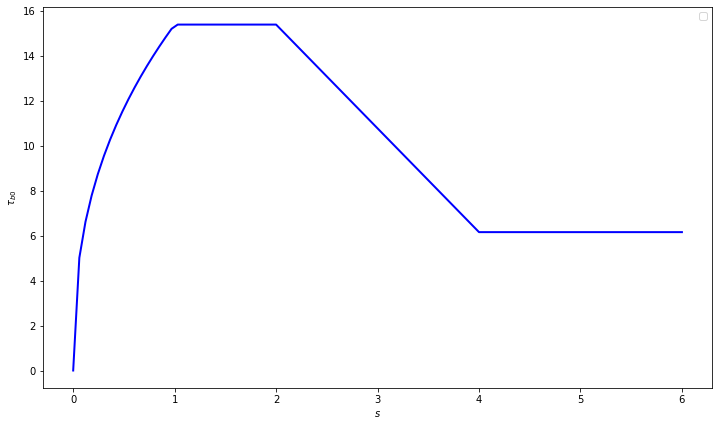

In [11]:
_, (ax1) = plt.subplots(1, 1, figsize=(12,7))
s_ = np.linspace(0, 6, 100)
tau_b0_val = get_tau_b0(s_)
ax1.plot(s_, tau_b0_val, color='blue', lw=2);
ax1.set_xlabel(r'$s$'); ax1.set_ylabel(r'$\tau_{b0}$')
ax1.legend()

## Dowel Action

### Baumann and Rusch Approach

According to Baumann and Rusch, the vertical displacement along the opening of the crack and the shear resistance resulting from dowel action is assumed to be linear elastic before the maximum shear force $V_{dmax}$ is reached. Thereafter, the shear resistance remains constant upon any further shear displacement. Therefore, the maximum shear force carried by dowel action is given as:
\begin{equation}
    V_{d\,max} =  1.64 b_n d_b f_c^{1/3}
    \label{eq: V_dmax}
\end{equation}
where, $b_n$ is the clear width of the beam $(b_w - n d_b)$. Here, $d_b, n, b_w$ represents diameter of bar, number of bars and width of beam respectively. 
\begin{equation}
    V_{da} =  V_{d\,max} \frac{\delta}{0.08}\,\mathrm{for\, \delta < 0.08 \,mm}
    \label{eq: V_daBR}
\end{equation}
where $\delta$ is vertical shear deformation.


In [12]:
delta = sp.Symbol('\delta', nonnegative = True)

In [13]:
b_n = b_w - n * d_b
b_n

In [14]:
V_d_max = 1.64 * b_n * d_b * f_c**(1/3)
V_d_max

In [15]:
V_da_br = sp.Piecewise(
    (V_d_max * (delta/0.08), delta < 0.08),
    (V_d_max , delta >= 0.08)
    ) 
V_da_br 

⎧                   0.333333333333333                                         
⎪12.5⋅\delta⋅d_b⋅f_c                 ⋅(1.64⋅b_w - 1.64⋅d_b⋅n)  for \delta < 0.
⎨                                                                             
⎪             0.333333333333333                                               
⎩      d_b⋅f_c                 ⋅(1.64⋅b_w - 1.64⋅d_b⋅n)            otherwise  

  
08
  
  
  

In [16]:
get_V_da_br = sp.lambdify((delta), V_da_br.subs(params), 'numpy')
get_V_da_br

<function _lambdifygenerated(Dummy_22)>

<img src="fig/dowel_fig_baumann.png" width="800"/>

#### Martin's Approach for calculating $V_{da}$ and $\delta_k$
Peak force for pre-peak and ductile post peak dowel deformation is calculated as:
\begin{equation}
    V_{da} =  V_{d\,max} \frac{\delta}{0.05}\left(2 - \frac{\delta}{0.05}\right)\,\mathrm{for\, \delta \leq 0.05 \,mm}
    \label{eq: V_da1}
\end{equation}
\begin{equation}
    V_{da} =  V_{d\,max} \frac{2.55 - \delta}{2.5}\,\mathrm{for \,\delta > 0.05 \,mm}
    \label{eq: V_da2}
\end{equation}
where $\delta$ is vertical shear deformation and is given as(SCPT):
\begin{equation}
    \delta = \varphi \left(\frac{y_1}{\tan{\beta_1}} + \frac{ y_2 }{\tan{\beta_2}} \right) 
    \label{eq: deltak}
\end{equation}
$\varphi, \beta_{1,2}, y_{1,2}$ rotation of center of rotation of shear crack, angles of the cracks and length of the cracks in vertical coordinates.

In [17]:
V_da = sp.Piecewise(
    (V_d_max * (delta/0.05) * (2 - (delta/0.05)), delta <= 0.05),
    (V_d_max * ((2.55 - delta) / 2.5), delta > 0.05)
    ) 
V_da

⎧                   0.333333333333333                                         
⎪20.0⋅\delta⋅d_b⋅f_c                 ⋅(2 - 20.0⋅\delta)⋅(1.64⋅b_w - 1.64⋅d_b⋅n
⎨                                                                             
⎪            0.333333333333333                                                
⎩     d_b⋅f_c                 ⋅(1.02 - 0.4⋅\delta)⋅(1.64⋅b_w - 1.64⋅d_b⋅n)    

                    
)  for \delta ≤ 0.05
                    
                    
       otherwise    

In [18]:
get_V_da = sp.lambdify((delta), V_da.subs(params), 'numpy')
get_V_da

<function _lambdifygenerated(Dummy_23)>

No handles with labels found to put in legend.


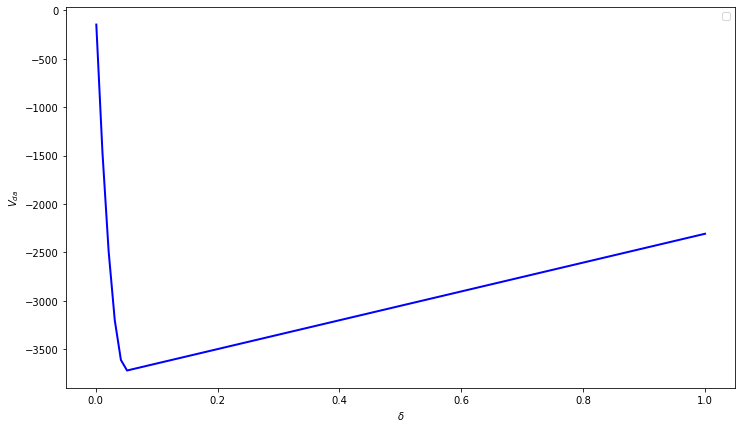

In [19]:
_, (ax1) = plt.subplots(1, 1, figsize=(12,7))
delta_ = np.linspace(0.001, 1, 100)
V_da_val = get_V_da(delta_)
ax1.plot(delta_, V_da_val, color='blue', lw=2);
ax1.set_xlabel(r'$\delta$'); ax1.set_ylabel(r'$V_{da}$')
ax1.legend()

## Aggregate Interlock

### Bazant's Approach refined by Gambarova
The Rough Crack Model proposed by Bazant was later refined by Gambarova in which he modified the relationship between normal stresses $\sigma_{ag}$ and crack kinematics (w and s). He further stated that the aggregate size $d_g$ plays a greater role in transferring shear. The stress can be transferred according to the following equations:
\begin{equation}
\sigma_{ag} = -0.62 \sqrt{w} \frac{r}{(1 + r^2)^{0.25}} \tau_{ag} \\
\tau_{ag} = \tau_0 \left( 1 - \sqrt{\frac{2 w}{d_g}}\right) r \frac{a_3 + a_4 \|r\|^3}{1 + a_4 r^4}
\end{equation}
where,
\begin{equation}
r = \frac{\delta}{w} \\
\tau_0 = 0.25 f_c \\
a_3 = \frac{2.45}{\tau_0} \\
a_4 = 2.44 \left( 1 - \frac{4}{\tau_0}\right)
\end{equation}

<img src="fig/aggregate_interlock.png" width="800"/>

In [20]:
w = sp.Symbol('w', nonnegative = True)
d_g  = sp.Symbol('d_g', nonnegative = True)

In [21]:
r = delta/w
r

In [22]:
tau_0 = 0.25 * f_c
tau_0

In [23]:
a_3  =  2.45/tau_0
a_3

In [24]:
a_4  = 2.44 * (1 - (4/tau_0))
a_4

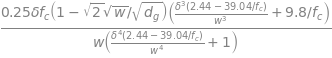

In [25]:
tau_ag = tau_0 * (1 - sp.sqrt((2 * w)/d_g)) * r * (a_3 + (a_4 * sp.Abs(r)**3)) / (1 + (a_4 *r**4))
tau_ag

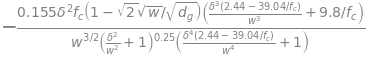

In [26]:
sigma_ag = -0.62 * sp.sqrt(w) * (r)/(1 + r**2)**0.25 * tau_ag
sigma_ag

In [27]:
params_ag = {
    f_c : 37.9, #MPa
    d_g : 22, ##mm
}

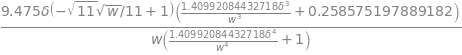

In [28]:
get_tau_ag = sp.lambdify((w, delta), tau_ag.subs(params_ag), 'numpy')
tau_ag.subs(params_ag)

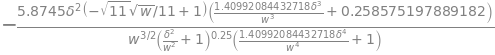

In [29]:
get_sigma_ag = sp.lambdify((w, delta), sigma_ag.subs(params_ag), 'numpy')
sigma_ag.subs(params_ag)

In [30]:
w_ = np.linspace(0.1, 1, 3)
tau_ag = np.zeros((100,3))
for i, w in enumerate(w_):
    delta_ = np.linspace(0.001, 1, 100)
    for j, delta in enumerate(delta_):
        tau_ag[j,i] = get_tau_ag(w, delta)
#print(tau_ag);

In [31]:
w_ = np.linspace(0.1, 1, 3)
sigma_ag = np.zeros((100,3))
for i, w in enumerate(w_):
    delta_ = np.linspace(0.001, 1, 100)
    for j, delta in enumerate(delta_):
        sigma_ag[j,i] = get_sigma_ag(w, delta)
#print(sigma_ag)

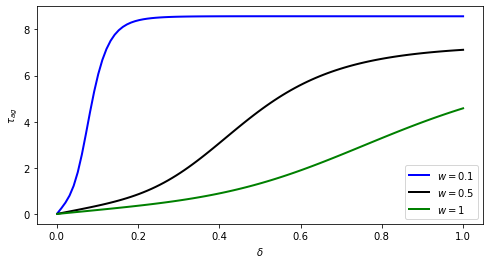

In [32]:
_, (ax1) = plt.subplots(1, 1, figsize=(8,4))
ax1.plot(delta_, tau_ag[:,0], color='blue', lw=2, label = (r'$w = 0.1$'))
ax1.plot(delta_, tau_ag[:,1], color='black', lw=2, label = (r'$w = 0.5$'))
ax1.plot(delta_, tau_ag[:,2], color='green', lw=2, label = (r'$w = 1$'))
ax1.set_xlabel(r'$\delta$'); ax1.set_ylabel(r'$\tau_{ag}$')
ax1.legend()

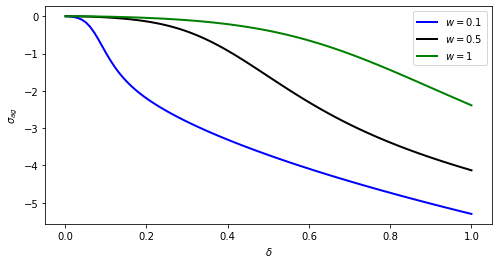

In [33]:
_, (ax1) = plt.subplots(1, 1, figsize=(8,4))
ax1.plot(delta_, sigma_ag[:,0], color='blue', lw=2, label = (r'$w = 0.1$'))
ax1.plot(delta_, sigma_ag[:,1], color='black', lw=2, label = (r'$w = 0.5$'))
ax1.plot(delta_, sigma_ag[:,2], color='green', lw=2, label = (r'$w = 1$'))
ax1.set_xlabel(r'$\delta$'); ax1.set_ylabel(r'$\sigma_{ag}$')
ax1.legend()

## Assumptions for tensile behavior (softening curve)

The mathematical bilinear softening cohesive stress vs crack opening is given as:
\begin{gather*}
\sigma = f_\mathrm{t} - (f_\mathrm{t} - \sigma_s(w_1)) \frac{w}{w_1} ; \: \mathrm{for}\; 0 \leq w \leq w_1
\end{gather*}
\begin{gather*}
\sigma = \sigma_s \frac{w_2 - w}{w_2 - w_1} ; \: \mathrm{for}\; w_1 \leq w \leq w_2
\end{gather*}

However, the parameters used in the bilinear softening curve can be evaluated by using formula by Xu. Hence,
\begin{gather*}
\sigma_s (CTOD_c) = \frac{f_t(2 - f_t \frac{CTOD_c}{G_f})}{\alpha_f} \\
w_1 = CTOD_c \\
w_2 = \alpha_f \frac{G_f}{f_t} \\
\alpha_f = \lambda - \frac{d_{max}}{8} \\
\end{gather*}
where, $f_t$ represents tensile strength that can be obtained by either splitting tests or by the formula $f_t = 0.4983 \sqrt f_c$ . Here, $G_f$, $\lambda$, $\alpha_f$ represents Fracture Energy, calibration factor, deformation coefficient of concrete respectively. Furthermore, $d_{max}$ depicts maximum size of coarse aggregate and $CTOD_c$ is the critical crack tip opening displacement which can be determined by replacing $x = a_0$ in the equation for $w_x$.

In [34]:
f_t = sp.Symbol('f_t', nonnegative = True)
CTOD_c = sp.Symbol('CTOD_c', nonnegative = True)
G_f  = sp.Symbol('G_f', nonnegative = True)
w_1 = CTOD_c
d_ag = sp.Symbol('d_{ag}', nonnegative = True)
lamda = sp.Symbol('\lambda', nonnegative = True)
w_2 = sp.Symbol('w_2', nonnegative = True)
w = sp.Symbol('w', nonnegative = True)

In [35]:
alpha_f = lamda - d_ag/8
alpha_f

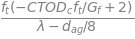

In [36]:
sigma_s = (f_t * (2 - f_t * (CTOD_c / G_f))) / alpha_f
sigma_s

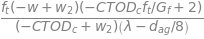

In [37]:
sigma_s * (w_2 - w) / (w_2 - w_1)

In [38]:
sigma_w = sp.Piecewise(
            (f_t - (f_t - sigma_s) * (w / w_1), w <= w_1 ),
            (sigma_s * (w_2 - w) / (w_2 - w_1),  w <= w_2),
)
sigma_w

⎧       ⎛        ⎛  CTOD_c⋅fₜ    ⎞⎞                
⎪       ⎜     fₜ⋅⎜- ───────── + 2⎟⎟                
⎪       ⎜        ⎝     G_f       ⎠⎟                
⎪     w⋅⎜fₜ - ────────────────────⎟                
⎪       ⎜                 d_{ag}  ⎟                
⎪       ⎜       \lambda - ──────  ⎟                
⎪       ⎝                   8     ⎠                
⎪fₜ - ─────────────────────────────  for CTOD_c ≥ w
⎨                 CTOD_c                           
⎪                                                  
⎪               ⎛  CTOD_c⋅fₜ    ⎞                  
⎪  fₜ⋅(-w + w₂)⋅⎜- ───────── + 2⎟                  
⎪               ⎝     G_f       ⎠                  
⎪─────────────────────────────────     for w ≤ w₂  
⎪               ⎛          d_{ag}⎞                 
⎪(-CTOD_c + w₂)⋅⎜\lambda - ──────⎟                 
⎩               ⎝            8   ⎠                 

In [39]:
params = {
    d_ag : 22,
    CTOD_c : 0.3,
    lamda : 4,
    f_t : 3,
    w_2 : 1,
    G_f : 0.5
}

In [40]:
get_sigma_w = sp.lambdify((w), sigma_w.subs(params), 'numpy')
sigma_w.subs(params)

⎧               3 - 8.4⋅w                 for w ≤ 0.3
⎨                                                    
⎩0.685714285714286 - 0.685714285714286⋅w   for w ≤ 1 

No handles with labels found to put in legend.


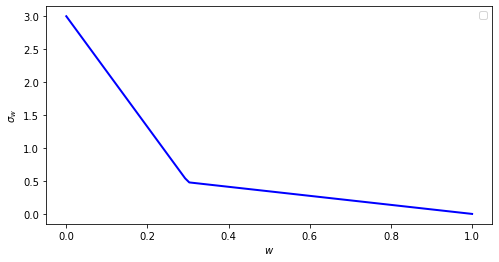

In [41]:
w_ = np.linspace(0, 1,100)
sigma_w_ = get_sigma_w(w_)
_, (ax1) = plt.subplots(1, 1, figsize=(8,4))
ax1.plot(w_, sigma_w_, color='blue', lw=2)
ax1.set_xlabel(r'$w$'); ax1.set_ylabel(r'$\sigma_{w}$')
ax1.legend()

In [42]:
sigma_w_ 

array([3.        , 2.91515152, 2.83030303, 2.74545455, 2.66060606,
       2.57575758, 2.49090909, 2.40606061, 2.32121212, 2.23636364,
       2.15151515, 2.06666667, 1.98181818, 1.8969697 , 1.81212121,
       1.72727273, 1.64242424, 1.55757576, 1.47272727, 1.38787879,
       1.3030303 , 1.21818182, 1.13333333, 1.04848485, 0.96363636,
       0.87878788, 0.79393939, 0.70909091, 0.62424242, 0.53939394,
       0.47792208, 0.47099567, 0.46406926, 0.45714286, 0.45021645,
       0.44329004, 0.43636364, 0.42943723, 0.42251082, 0.41558442,
       0.40865801, 0.4017316 , 0.39480519, 0.38787879, 0.38095238,
       0.37402597, 0.36709957, 0.36017316, 0.35324675, 0.34632035,
       0.33939394, 0.33246753, 0.32554113, 0.31861472, 0.31168831,
       0.3047619 , 0.2978355 , 0.29090909, 0.28398268, 0.27705628,
       0.27012987, 0.26320346, 0.25627706, 0.24935065, 0.24242424,
       0.23549784, 0.22857143, 0.22164502, 0.21471861, 0.20779221,
       0.2008658 , 0.19393939, 0.18701299, 0.18008658, 0.17316

## Menetry-William Failure Surface (Compressive Model)
This model consists of an ascending branch that represents the hardening phase. The material is found to behave linearly in the hardening phase upto a compressive stress value of $f_{co} = 2 f_t$. The nonlinear behavior is given by:
\begin{equation}
\sigma_c = f_{co} + (f_c - f_{co}) \sqrt{1 - \left(\frac{\epsilon_{cp} - \epsilon_{p}}{\epsilon_{cp}}\right)^2}
\end{equation}
here, $\epsilon_p, \epsilon_{cp}$ is the plastic strain, plastic strain corresponding to compressive strength. 

In [43]:
eps_cp = sp.Symbol('\epsilon_{cp}', nonnegative = True)
eps_p = sp.Symbol('\epsilon_{p}', nonnegative = True)

In [44]:
f_co = 2* f_t
f_co

In [45]:
sigma_c = sp.Piecewise(
(2 * f_t, eps_p == 0),
(f_co + (f_c - f_co) * sp.sqrt(1 - ((eps_cp - eps_p)/(eps_cp))**2), eps_p <= eps_cp),
(f_c, eps_p > eps_cp)
)
sigma_c

⎧             _____________________________________                           
⎪            ╱                                   2                            
⎪           ╱      (\epsilon_{cp} - \epsilon_{p})                             
⎪2⋅fₜ +    ╱   1 - ─────────────────────────────── ⋅(f_c - 2⋅fₜ)  for \epsilon
⎨         ╱                              2                                    
⎪       ╲╱                  \epsilon_{cp}                                     
⎪                                                                             
⎪                              f_c                                           o
⎩                                                                             

                    
                    
                    
_{cp} ≥ \epsilon_{p}
                    
                    
                    
therwise            
                    

In [46]:
params = {
    f_t : 3,
    f_c : 37.9,
    eps_cp : 0.0014
}

In [47]:
get_sigma_c = sp.lambdify((eps_p), sigma_c.subs(params), 'numpy')
get_sigma_c

<function _lambdifygenerated(Dummy_30)>

No handles with labels found to put in legend.


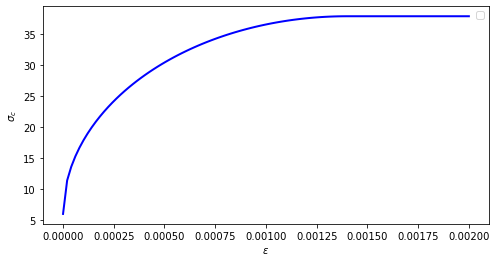

In [48]:
eps_p_ = np.linspace(0, 0.0020, 100)
sigma_c_ = get_sigma_c(eps_p_)
_, (ax1) = plt.subplots(1, 1, figsize=(8,4))
ax1.plot(eps_p_, sigma_c_, color='blue', lw=2)
ax1.set_xlabel(r'$\epsilon$'); ax1.set_ylabel(r'$\sigma_{c}$')
ax1.legend()

## Tension Model experimentally derived by Hordijk
The exponential function of the crack opening is given by:
\begin{equation}
\sigma_t = f_t \left( 1 + \left(c_1\frac{w_t}{w_{tc}}\right)^3\right) \exp\left( -c_2 \frac{w_t}{w_{tc}}\right)-\left(\frac{w_t}{w_{tc}}\right)(1+c_1^3)\exp(-c_2)
\end{equation}

In [49]:
w_t = sp.Symbol('w_t', nonnegative = True)
#w_tc = sp.Symbol('w_{tc}', nonnegative = True)
c_2 = sp.Symbol('c_2', nonnegative = True)
c_1 = sp.Symbol('c_1', nonnegative = True)

In [50]:
w_tc = 5.14 * G_f/f_t
w_tc

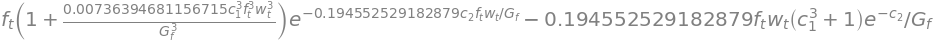

In [51]:
sigma_t = f_t * (1 + ((c_1 * w_t)/(w_tc))**3) * sp.exp((-c_2* w_t)/(w_tc)) - (w_t/w_tc) * (1 + c_1**3) * sp.exp(-c_2)
sigma_t

In [52]:
params = {
    c_1 : 3,
    c_2 : 6.93,
    G_f : 0.5,
    f_t : 3
}

In [53]:
w_tc.subs(params)

In [54]:
get_sigma_t = sp.lambdify((w_t), sigma_t.subs(params), 'numpy')
get_sigma_t

<function _lambdifygenerated(w_t)>

No handles with labels found to put in legend.


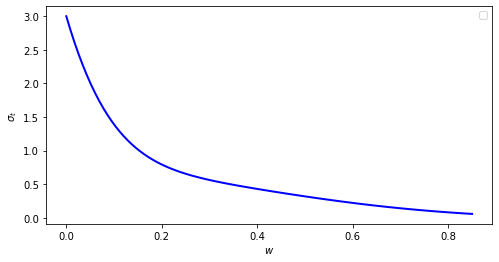

In [55]:
w_t_ = np.linspace(0, 0.85, 100)
sigma_t_ = get_sigma_t(w_t_)
_, (ax1) = plt.subplots(1, 1, figsize=(8,4))
ax1.plot(w_t_, sigma_t_, color='blue', lw=2)
ax1.set_xlabel(r'$w$'); ax1.set_ylabel(r'$\sigma_{t}$')
ax1.legend()